In [35]:
pip install imagehash

   ---------------------------------------- 0.0/296.5 kB ? eta -:--:--
   ---------------------------------------- 0.0/296.5 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/296.5 kB 445.2 kB/s eta 0:00:01
   ------------ -------------------------- 92.2/296.5 kB 880.9 kB/s eta 0:00:01
   -------------------------- ------------- 194.6/296.5 kB 1.3 MB/s eta 0:00:01
   -------------------------------------- - 286.7/296.5 kB 1.6 MB/s eta 0:00:01
   ---------------------------------------- 296.5/296.5 kB 1.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install tensorflow

     ---------------------------------------- 0.0/48.7 kB ? eta -:--:--
     ---------------------------------------- 48.7/48.7 kB 2.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/385.0 MB ? eta -:--:--
   ---------------------------------------- 0.4/385.0 MB 8.7 MB/s eta 0:00:45
   ---------------------------------------- 0.9/385.0 MB 9.2 MB/s eta 0:00:42
   ---------------------------------------- 1.3/385.0 MB 9.3 MB/s eta 0:00:42
   ---------------------------------------- 1.9/385.0 MB 9.9 MB/s eta 0:00:39
   ---------------------------------------- 2.4/385.0 MB 10.2 MB/s eta 0:00:38
   ---------------------------------------- 2.9/385.0 MB 10.3 MB/s eta 0:00:38
   ---------------------------------------- 3.4/385.0 MB 10.3 MB/s eta 0:00:37
   ---------------------------------------- 3.9/385.0 MB 10.5 MB/s eta 0:00:37
   ---------------------------------------- 4.4/385.0 MB 10.7 MB/s eta 0:00:36
   ---------------------------------------- 4.8/385.0 MB 10.2 MB/s eta

In [13]:
# Write your imports here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from skimage.io import imread
from skimage.transform import resize
import imagehash
from PIL import Image

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

# Working with Images Lab
## Information retrieval, preprocessing, and feature extraction

In this lab, you'll work with images of felines (cats), which have been classified according to their taxonomy. Each subfolder contains images of a particular species. The dataset is located [here](https://www.kaggle.com/datasets/datahmifitb/felis-taxonomy-image-classification) but it's also provided to you in the `data/` folder.

### Problem 1. Some exploration (1 point)
How many types of cats are there? How many images do we have of each? What is a typical image size? Are there any outliers in size?

In [3]:
root_dir = 'data'
cat_types = os.listdir(root_dir)


all_catas_data = list()

for cat_type in cat_types:
  cat_type_path = os.path.join(root_dir, cat_type)

  image_files = [img for img in os.listdir(cat_type_path) if img.endswith(".jpg")]

  for image_file in image_files:
    image_path = os.path.join(cat_type_path, image_file)
    data = imread(image_path)
    image_height ,image_width, image_channels = data.shape

    hash = imagehash.average_hash(Image.open(image_path))

    all_catas_data.append([ image_file, cat_type, data, data.nbytes, image_width, image_height, image_channels, hash ])


all_columns = ["file_name", "cat_type", "data", "byte_size", "image_width", "image_height", "image_channels", "hash" ]
all_coluns_except_data = [x for x in all_columns if x != "data"]

cats_df =pd.DataFrame(all_catas_data, columns=all_columns)

In [4]:
print(f'cat_types count {len(cats_df.cat_type.unique())}')

cats_df.groupby("cat_type")['cat_type'].value_counts()

cat_types count 7


cat_type
african-wildcat         91
blackfoot-cat           79
chinese-mountain-cat    42
domestic-cat            64
european-wildcat        85
jungle-cat              86
sand-cat                72
Name: count, dtype: int64

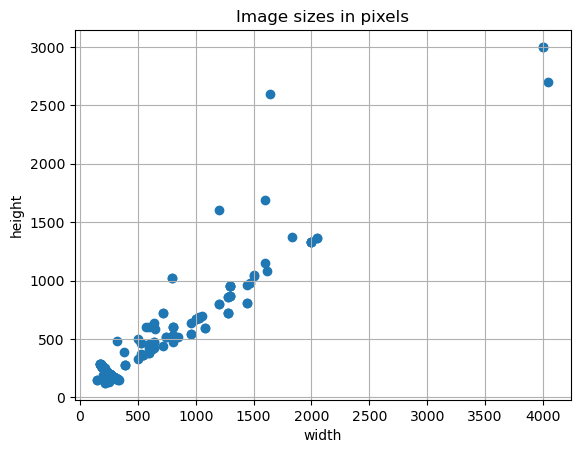

In [5]:
plt.scatter(cats_df["image_width"],cats_df["image_height"])
plt.xlabel("width")
plt.ylabel("height")
plt.title("Image sizes in pixels")
plt.grid()

plt.show()

It seems we have outliers - with width >=2500 or height >= 1500.
Lets coutn them:

In [6]:
cats_df.loc[(cats_df["image_height"] >= 1500) | (cats_df["image_width"] >= 2500)][all_coluns_except_data]

,file_name,cat_type,byte_size,image_width,image_height,image_channels,hash
175,ch (14).jpg,chinese-mountain-cat,36000000,4000,3000,3,fffc002000180000
180,ch (19).jpg,chinese-mountain-cat,36000000,4000,3000,3,fffc003810000000
189,ch (27).jpg,chinese-mountain-cat,12813336,1644,2598,3,00fbe3c3cf87014c
209,ch (7).jpg,chinese-mountain-cat,32728095,4045,2697,3,383e3f7f673c7c02
278,eu (11).jpg,european-wildcat,5767200,1200,1602,3,ffc7c7e3c1e0e0f1
283,eu (16).jpg,european-wildcat,8107200,1600,1689,3,ffd802f3f3f3c100


### Problem 2. Duplicat(e)s (1 point)
Find a way to filter out (remove) identical images. I would recommnend using file hashes, but there are many approaches. Keep in mind that during file saving, recompression, etc., a lot of artifacts can change the file content (bytes), but not visually.

In [7]:
found_duplicte_hashes = []
all_items = cats_df[["file_name", "hash"]].iterrows()
listed_all_items = list(cats_df[["file_name", "hash"]].iterrows())

total_count = len(listed_all_items)

checked_dulicates_files = []
duplicated_groups = []
for idx, item in all_items:
  if (idx == total_count -1):
    break
  current_hash = item["hash"]

  similar_files = [ other_item["file_name"]  for _, other_item in listed_all_items[idx+1:] if other_item["file_name"] not in checked_dulicates_files and other_item["hash"] - current_hash < 10 ]

  if (len(similar_files) > 0):
    checked_dulicates_files.extend(similar_files)
    duplicate_group = [item["file_name"]]
    duplicate_group.extend(similar_files)
    duplicated_groups.append(duplicate_group)

print(f'duplicated files groups: {len(duplicated_groups)}')
print(duplicated_groups)


duplicated files groups: 84
[['af (11).jpg', 'af (37).jpg'], ['af (13).jpg', 'af (47).jpg'], ['af (14).jpg', 'af (64).jpg', 'bc (19).jpg', 'bc (43).jpg', 'ch (23).jpg', 'dc (17).jpg', 'jg (37).jpg', 'sd (18).jpg'], ['af (16).jpg', 'af (74).jpg'], ['af (17).jpg', 'eu (24).jpg', 'eu (76).jpg', 'eu (79).jpg', 'jg (62).jpg', 'sd (50).jpg'], ['af (26).jpg', 'eu (47).jpg'], ['af (27).jpg', 'af (32).jpg'], ['af (28).jpg', 'af (86).jpg'], ['af (29).jpg', 'af (66).jpg', 'eu (33).jpg', 'eu (55).jpg'], ['af (33).jpg', 'dc (52).jpg', 'dc (63).jpg', 'eu (11).jpg', 'jg (26).jpg'], ['af (38).jpg', 'af (51).jpg'], ['af (42).jpg', 'af (9).jpg'], ['af (50).jpg', 'af (61).jpg'], ['af (56).jpg', 'af (76).jpg'], ['af (60).jpg', 'jg (13).jpg', 'jg (68).jpg'], ['af (64).jpg', 'dc (13).jpg'], ['af (65).jpg', 'af (79).jpg', 'eu (23).jpg', 'eu (51).jpg'], ['af (66).jpg', 'bc (60).jpg', 'jg (63).jpg'], ['af (68).jpg', 'eu (50).jpg', 'eu (74).jpg'], ['af (69).jpg', 'dc (5).jpg'], ['af (7).jpg', 'jg (65).jpg'], ['

### Problem 3. Loading a model (2 points)
Find a suitable, trained convolutional neural network classifier. I recommend `ResNet50` as it's small enough to run well on any machine and powerful enough to make reasonable predictions. Most ready-made classifiers have been trained for 1000 classes.

You'll need to install libraries and possibly tinker with configurations for this task. When you're done, display the total number of layers and the total number of parameters. For ResNet50, you should expect around 50 layers and 25M parameters.

In [8]:
res_net_model = ResNet50()

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


In [11]:
# res_net_model.summary()
print(f"Number of layers: {len(res_net_model.layers)}")
print(f"Number of parameters: {res_net_model.count_params():_}")

Number of layers: 177
Number of parameters: 25_636_712


### Problem 4. Prepare the images (1 point)
You'll need to prepare the images for passing to the model. To do so, they have to be resized to the same dimensions. Most available models have a specific requirement for sizes. You may need to do additional preprocessing, depending on the model requirements. These requirements should be easily available in the model documentation.

In [14]:
cats_df["resized"] = cats_df["data"].apply(lambda data: resize(data, (224, 224)))

### Problem 5. Load the images efficiently (1 point)
Now that you've seen how to prepare the images for passing to the model... find a way to do it efficiently. Instead of loading the entire dataset in the RAM, read the images in batches (e.g. 4 images at a time). The goal is to read these, preprocess them, maybe save the preprocessed results in RAM.

If you've already done this in one of the previous problems, just skip this one. You'll get your point for it.

\* Even better, save the preprocessed image arrays (they will not be valid .jpg file) as separate files, so you can load them "lazily" in the following steps. This is a very common optimization to work with large datasets.

### Problem 6. Predictions (1 point)
Finally, you're ready to get into the meat of the problem. Obtain predictions from your model and evaluate them. This will likely involve manual work to decide how the returned classes relate to the original ones.

Create a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) to evaluate the classification.

In [ ]:
cats_df["resized"].items() 

### Problem 7. Grayscale (1 point)
Converting the images to grayscale should affect the classification negatively, as we lose some of the color information.

Find a way to preprocess the images to grayscale (using what you already have in Problem 4 and 5), pass them to the model, and compare the classification results to the previous ones.

### Problem 8. Deep image features (1 point)
Find a way to extract one-dimensional vectors (features) for each (non-grayscale) image, using your model. This is typically done by "short-circuiting" the model output to be an intermediate layer, while keeping the input the same. 

In case the outputs (also called feature maps) have different shapes, you can flatten them in different ways. Try to not create huge vectors; the goal is to have a relatively short sequence of numbers which describes each image.

You may find a tutorial like [this](https://towardsdatascience.com/exploring-feature-extraction-with-cnns-345125cefc9a) pretty useful but note your implementation will depend on what model (and framework) you've decided to use.

It's a good idea to save these as one or more files, so you'll spare yourself a ton of preprocessing.

### Problem 9. Putting deep image features to use (1 points)
Try to find similar images, using a similarity metric on the features you got in the previous problem. Two good metrics are `mean squared error` and `cosine similarity`. How do they work? Can you spot images that look too similar? Can you explain why?

\* If we were to take Fourier features (in a similar manner, these should be a vector of about the same length), how do they compare to the deep features; i.e., which features are better to "catch" similar images?

### * Problem 10. Explore, predict, and evaluate further
You can do a ton of things here, at your desire. For example, how does masking different areas of the image affect classification - a method known as **saliency map** ([info](https://en.wikipedia.org/wiki/Saliency_map))? Can we detect objects? Can we significantly reduce the number of features (keeping the quality) that we get? Can we reliably train a model to predict our own classes? We'll look into these in detail in the future.